# MCMC Diagnostic Plots

This notebook is to visulize the MCMC runs that are computed in 'ecc_search.ipynb'

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os, glob
import numpy as np
import arviz as az
from enterprise_extensions.model_utils import bayes_fac
import ecc_res
import libstempo as T
import libstempo.plot as LP, libstempo.toasim as LT
import ephem
import warnings
warnings.filterwarnings('ignore')

Cannot import PINT? Meh...


In [3]:
datadir = '/home/bcheeseboro/nanograv_proj/enterprise_proj/ecc_search_data/ideal_data_test/detection_runs/fixed_coords/correct_dist/efac_added/logmc_9.5/source2/run3/'

In [4]:
#cw_dir = '../cw_search/logmc_9/source7/run1/'
parfile = '../../ecc_signal_create/small_pta/B1855+09_NANOGrav_11yv0.gls.par'
timfile = '../../ecc_signal_create/small_pta/B1855+09_NANOGrav_11yv0.tim'

In [4]:
with open(datadir+'params.txt', 'r') as f:
    ecc_param_list = f.read().splitlines()

In [5]:
ecc_chain_run_1 = np.loadtxt(datadir+'chain_1.txt')

In [6]:
#ecc_burn_run_1 = int(0.25 * ecc_chain_run_1.shape[0]) + 20000
#ecc_chain_run_1 = ecc_chain_run_1[ecc_burn_run_1:]

ecc_dict_run_1 = {}
for i,par in enumerate(ecc_param_list):
    ecc_dict_run_1[par] = ecc_chain_run_1[:,i]
az_from_ecc_chains = az.convert_to_inference_data(ecc_dict_run_1)

In [7]:
ecc_param_list

['e0', 'log10_forb', 'log10_mc', 'q']

In [8]:
np.shape(ecc_chain_run_1)

(150200, 8)

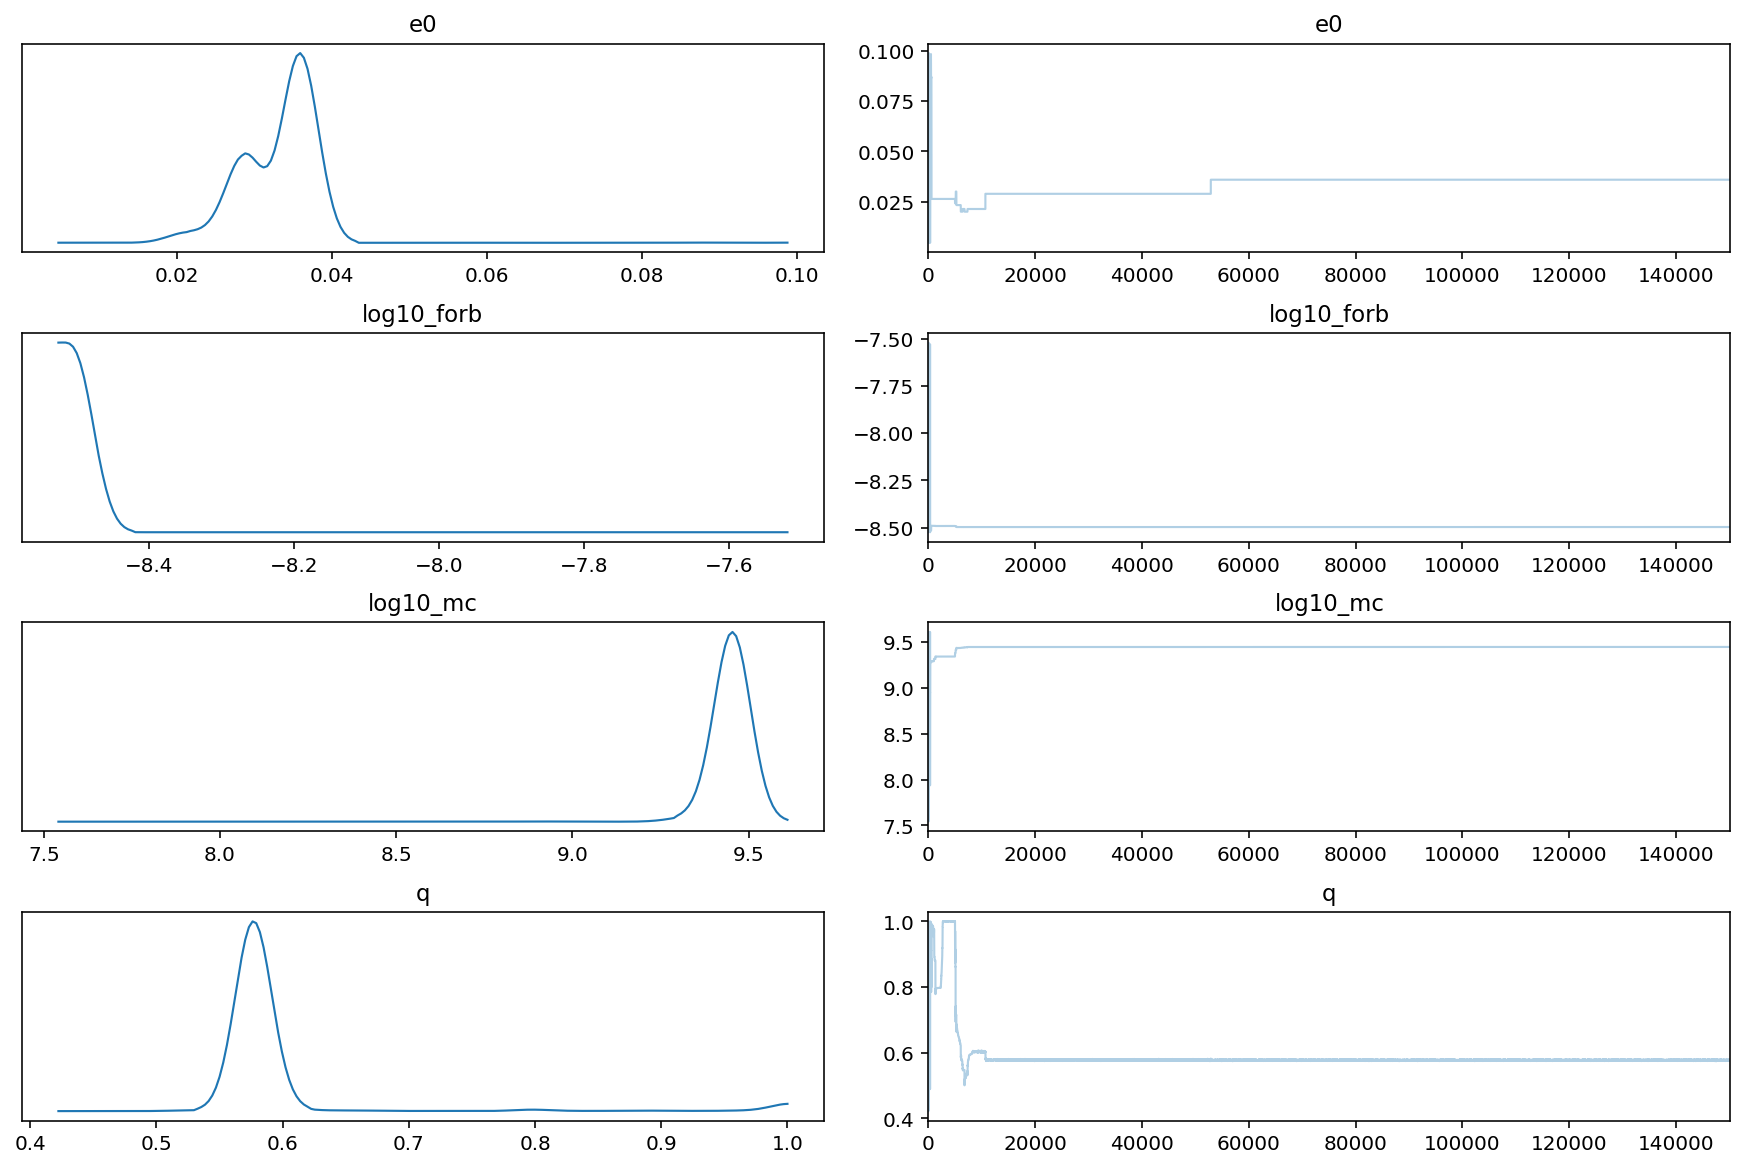

In [9]:
az.plot_trace(az_from_ecc_chains,var_names=ecc_param_list, backend='matplotlib');
plt.savefig(datadir+'arviz_trace_plot.jpg')

In [20]:
ecc_chain_run_1[:,22]

array([-11.81844236, -11.81844236, -11.81844236, ..., -11.81215794,
       -11.81215794, -11.81215794])

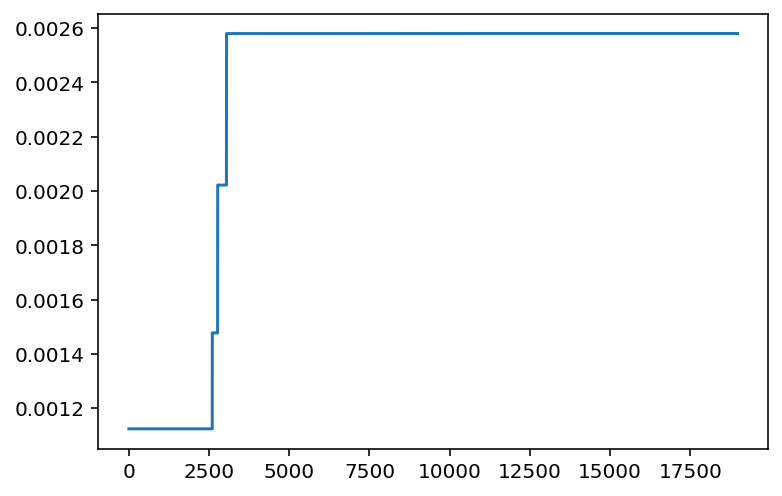

In [9]:
plt.plot(ecc_chain_run_1[:,20])

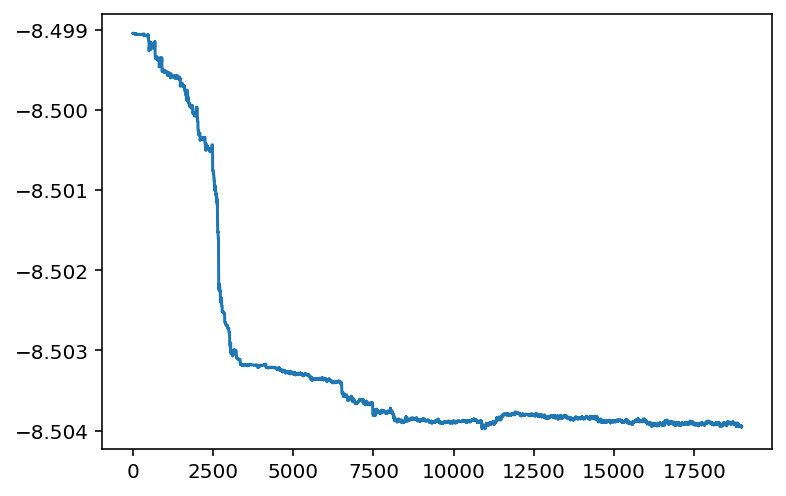

In [10]:
plt.plot(ecc_chain_run_1[:,21])

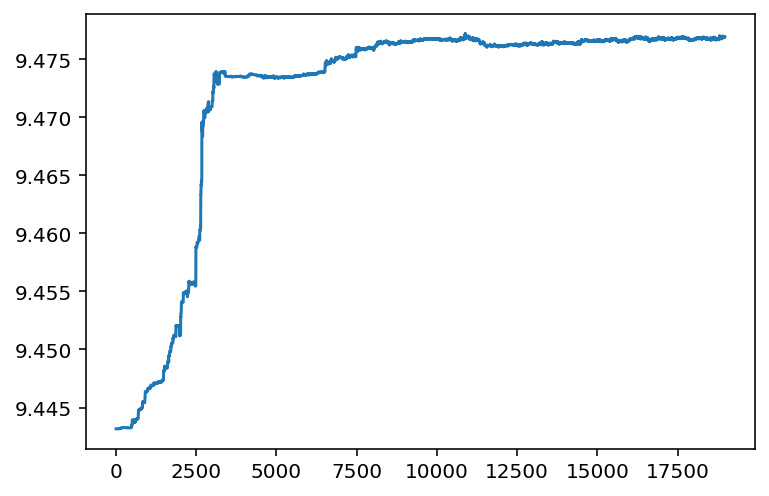

In [11]:
plt.plot(ecc_chain_run_1[:,22])

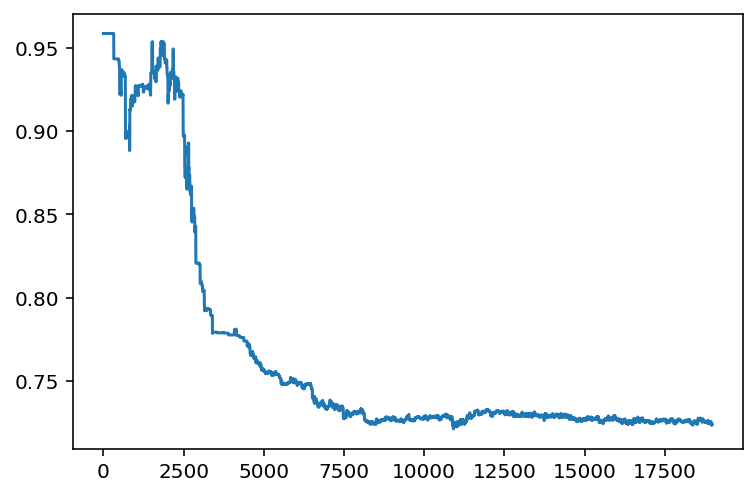

In [12]:
plt.plot(ecc_chain_run_1[:,23])

In [7]:
psr = T.tempopulsar(parfile = parfile,timfile = timfile)

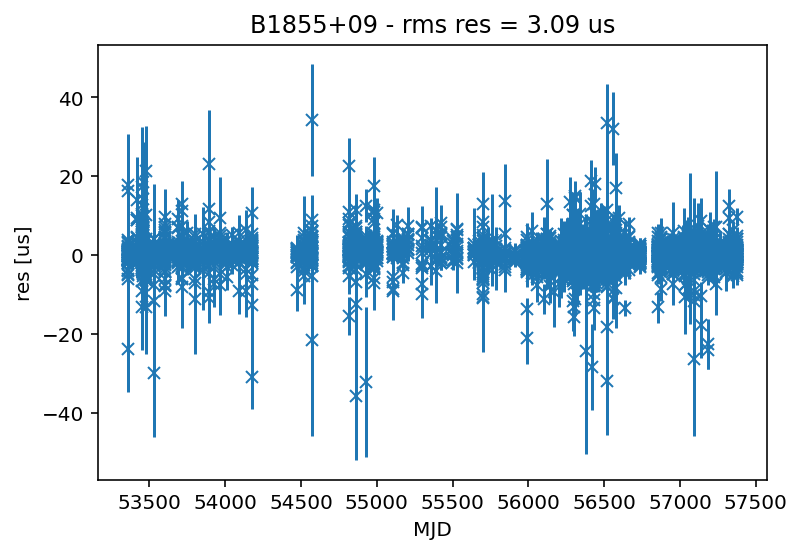

In [8]:
LP.plotres(psr)

In [9]:
#injected params
gwphi = 5.02
gwtheta = 2.51
log10_dist = 6
q = 1
log10_mc = 9.5
log10_forb = -8.5
e0 = 0.01
l0 = 0
gamma0 = 0
inc = 1.0471975511965976
psi = 0

In [10]:
LT.make_ideal(psr)
#convert pulsar sky location to proper frame
fac = 180./np.pi
coords = ephem.Equatorial(ephem.Ecliptic(str(psr['ELONG'].val*fac), 
                                                 str(psr['ELAT'].val*fac)))
ptheta = np.pi/2 - float(repr(coords.dec))
pphi = float(repr(coords.ra))
pdist = 0.9 #distance of pulsar in kpc

toas = np.double(psr.toas())*86400 #toas
residuals = ecc_res.add_ecc_cgw(toas, ptheta, pphi, pdist, gwtheta, gwphi, log10_mc, q, log10_forb, e0, l0, gamma0, 
                    inc, psi, log10_dist, pphase = None, gamma_P = None, tref = 59000, 
                    psrterm = True, evol = True, waveform_cal = True, res = 'Both')
psr.stoas[:] += residuals/86400

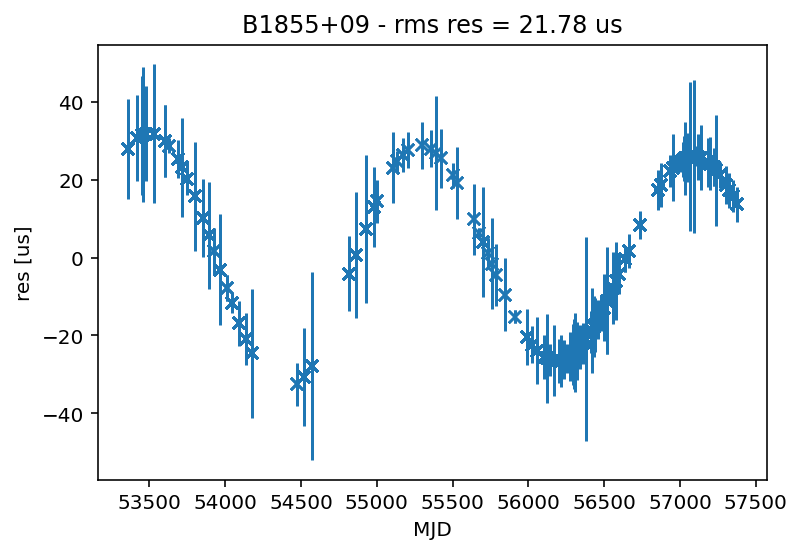

In [11]:
LP.plotres(psr)

In [12]:
residual_r = []
toas_r = []
idxs = np.random.randint(0, len(ecc_chain_run_1), 100)

#recovered parameters
q_r = ecc_chain_run_1[idxs,3]
log10_mc_r = ecc_chain_run_1[idxs,2]
log10_forb_r = ecc_chain_run_1[idxs,1]
e0_r = ecc_chain_run_1[idxs,0]

In [13]:
for ii, idx in enumerate(idxs):
    psr_r = T.tempopulsar(parfile = parfile,timfile = timfile)
    #make the pulsar residuals flat
    LT.make_ideal(psr_r)
    toas = np.double(psr_r.toas())*86400 #toas
    #convert pulsar sky location to proper frame
    fac = 180./np.pi
    coords = ephem.Equatorial(ephem.Ecliptic(str(psr_r['ELONG'].val*fac), 
                                                 str(psr_r['ELAT'].val*fac)))
    ptheta = np.pi/2 - float(repr(coords.dec))
    pphi = float(repr(coords.ra))
    #Inject signal into set of pulsars
    pdist = 0.9 #distance of pulsar in kpc
    residual = ecc_res.add_ecc_cgw(toas, ptheta, pphi, pdist, gwtheta, gwphi, log10_mc_r[ii], q_r[ii], log10_forb_r[ii], e0_r[ii], l0, gamma0, 
                    inc, psi, log10_dist, pphase = None, gamma_P = None, tref = 59000, 
                    psrterm = True, evol = True, waveform_cal = True, res = 'Both')
    
    psr_r.stoas[:] += (residual)/86400
    residual_r.append(residual)
    toas_r.append(psr_r.toas())

In [13]:
residual_r

[array([-3.58753527e-26, -3.58753527e-26, -3.58753527e-26, ...,
        -2.00164917e-13, -2.00164917e-13, -2.00164917e-13]),
 array([-3.58625073e-26, -3.58625073e-26, -3.58625073e-26, ...,
        -2.00089511e-13, -2.00089511e-13, -2.00089511e-13]),
 array([-3.58661067e-26, -3.58661067e-26, -3.58661067e-26, ...,
        -2.00051923e-13, -2.00051923e-13, -2.00051923e-13]),
 array([-3.58640093e-26, -3.58640093e-26, -3.58640093e-26, ...,
        -2.00082606e-13, -2.00082606e-13, -2.00082606e-13]),
 array([-3.58724532e-26, -3.58724532e-26, -3.58724532e-26, ...,
        -2.00105808e-13, -2.00105808e-13, -2.00105808e-13]),
 array([-3.58581031e-26, -3.58581031e-26, -3.58581031e-26, ...,
        -2.00006603e-13, -2.00006603e-13, -2.00006603e-13]),
 array([-3.58662983e-26, -3.58662983e-26, -3.58662983e-26, ...,
        -2.00082633e-13, -2.00082633e-13, -2.00082633e-13]),
 array([-3.58729239e-26, -3.58729239e-26, -3.58729239e-26, ...,
        -2.00065638e-13, -2.00065638e-13, -2.00065638e-13]),


Text(0, 0.5, 'res[ms]')

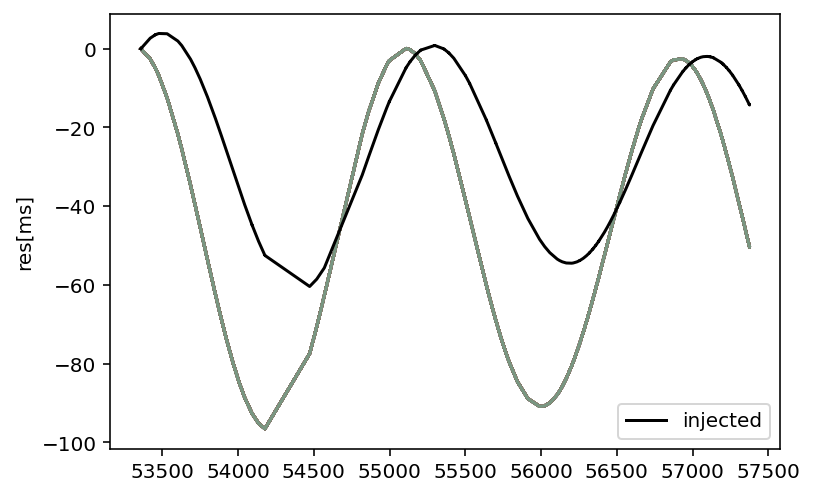

In [14]:
for ii, residual in enumerate(residual_r):
    plt.plot(toas_r[ii], residual/1e-6, alpha=0.3)
plt.plot(psr.toas(), residuals/1e-6, color='black', label='injected')
plt.legend()
plt.ylabel('res[ms]')

# Multichain stuff

In [4]:
chains = sorted(glob.glob(datadir+'chain_*'))

In [5]:
chains

['../ecc_search_data/ideal_data_test/detection_runs/closer_dist/quasi_circ/pt_run/run2/chain_1.0.txt',
 '../ecc_search_data/ideal_data_test/detection_runs/closer_dist/quasi_circ/pt_run/run2/chain_1.3779644730092273.txt',
 '../ecc_search_data/ideal_data_test/detection_runs/closer_dist/quasi_circ/pt_run/run2/chain_1.8987860888755976.txt',
 '../ecc_search_data/ideal_data_test/detection_runs/closer_dist/quasi_circ/pt_run/run2/chain_12.998827038545741.txt',
 '../ecc_search_data/ideal_data_test/detection_runs/closer_dist/quasi_circ/pt_run/run2/chain_17.911921849907777.txt',
 '../ecc_search_data/ideal_data_test/detection_runs/closer_dist/quasi_circ/pt_run/run2/chain_2.6164597723147147.txt',
 '../ecc_search_data/ideal_data_test/detection_runs/closer_dist/quasi_circ/pt_run/run2/chain_24.681991952490634.txt',
 '../ecc_search_data/ideal_data_test/detection_runs/closer_dist/quasi_circ/pt_run/run2/chain_3.6053886113074887.txt',
 '../ecc_search_data/ideal_data_test/detection_runs/closer_dist/quasi_c

In [6]:
all_chains = []
for chain_dir in chains:
    chain = np.loadtxt(chain_dir)
    all_chains.append(chain)

In [7]:
np.shape(all_chains)

(15,)

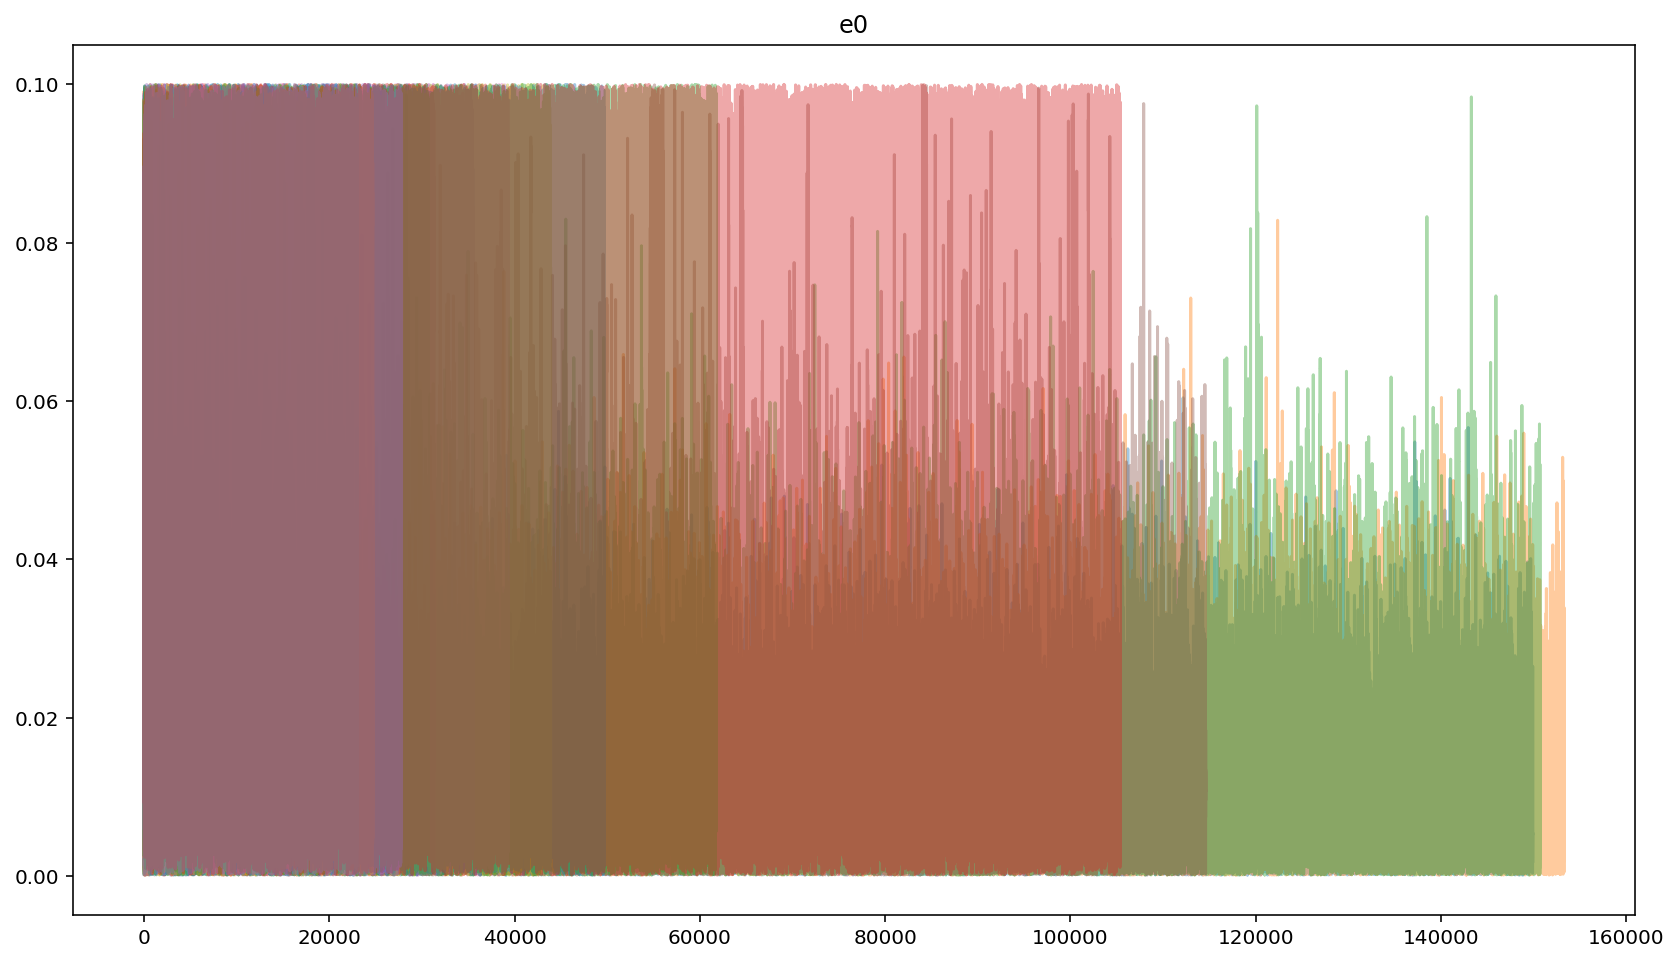

In [29]:
fig = plt.figure(figsize=(14,8))
for chain in all_chains:
    plt.plot(chain[:,10], alpha=0.4)
plt.title('e0')
plt.savefig(datadir+'e0_traces.png')

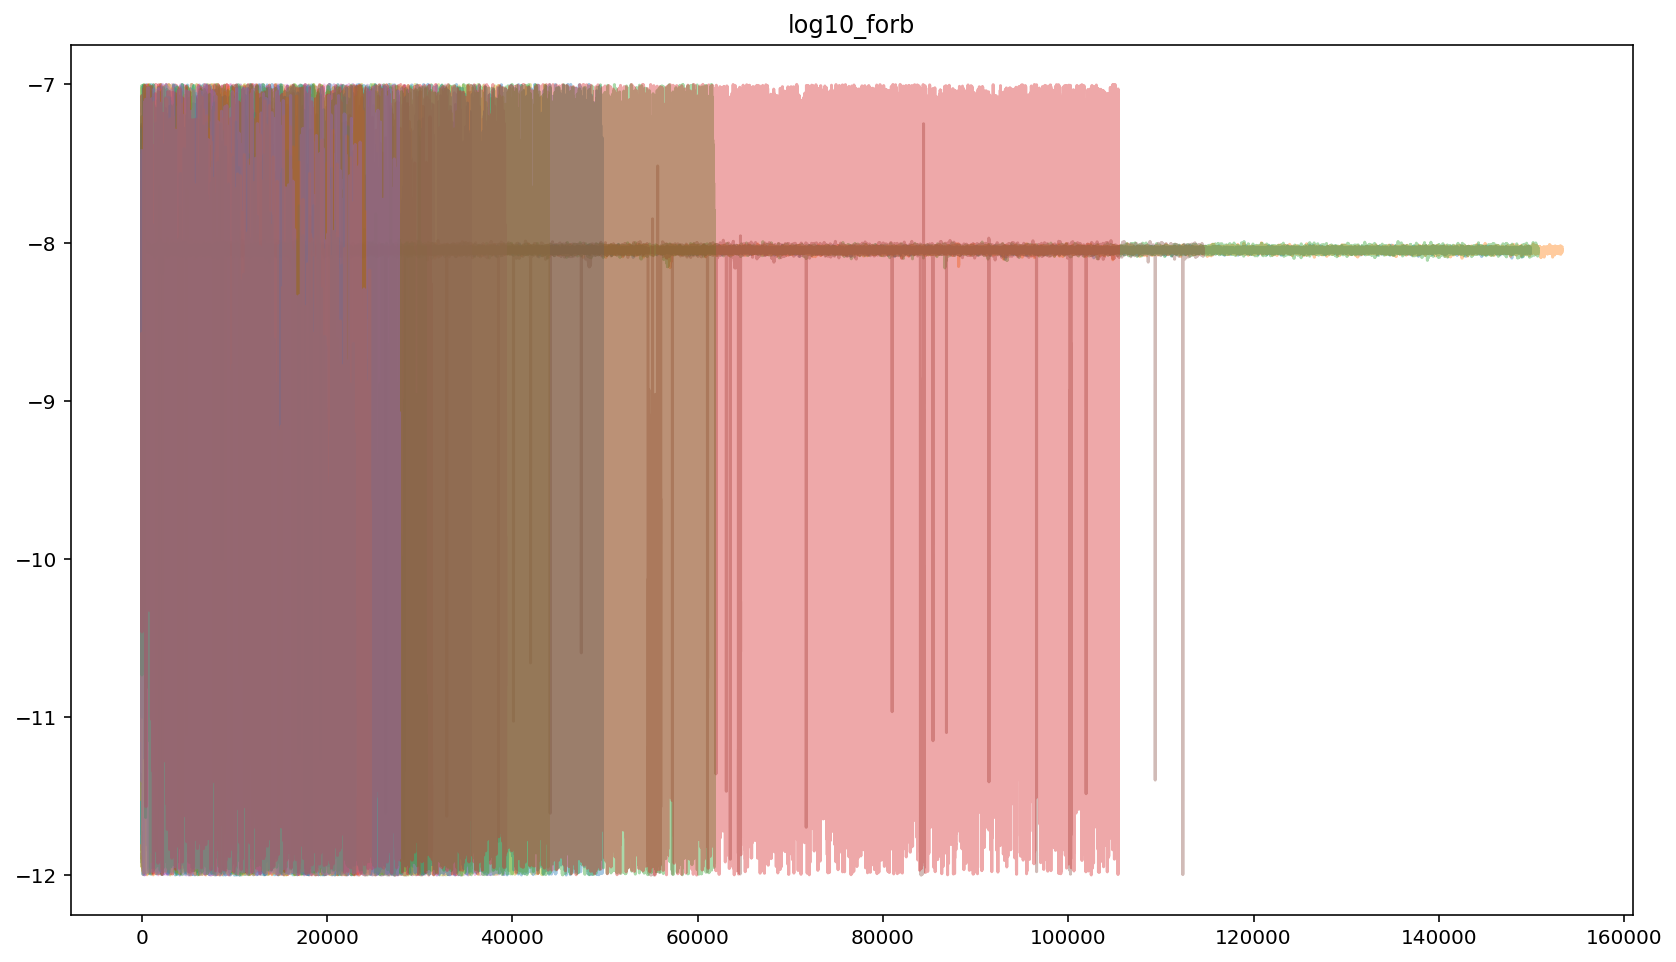

In [30]:
fig = plt.figure(figsize=(14,8))
for chain in all_chains:
    plt.plot(chain[:,11], alpha=0.4)
plt.title('log10_forb')
plt.savefig(datadir+'forb_traces.png')

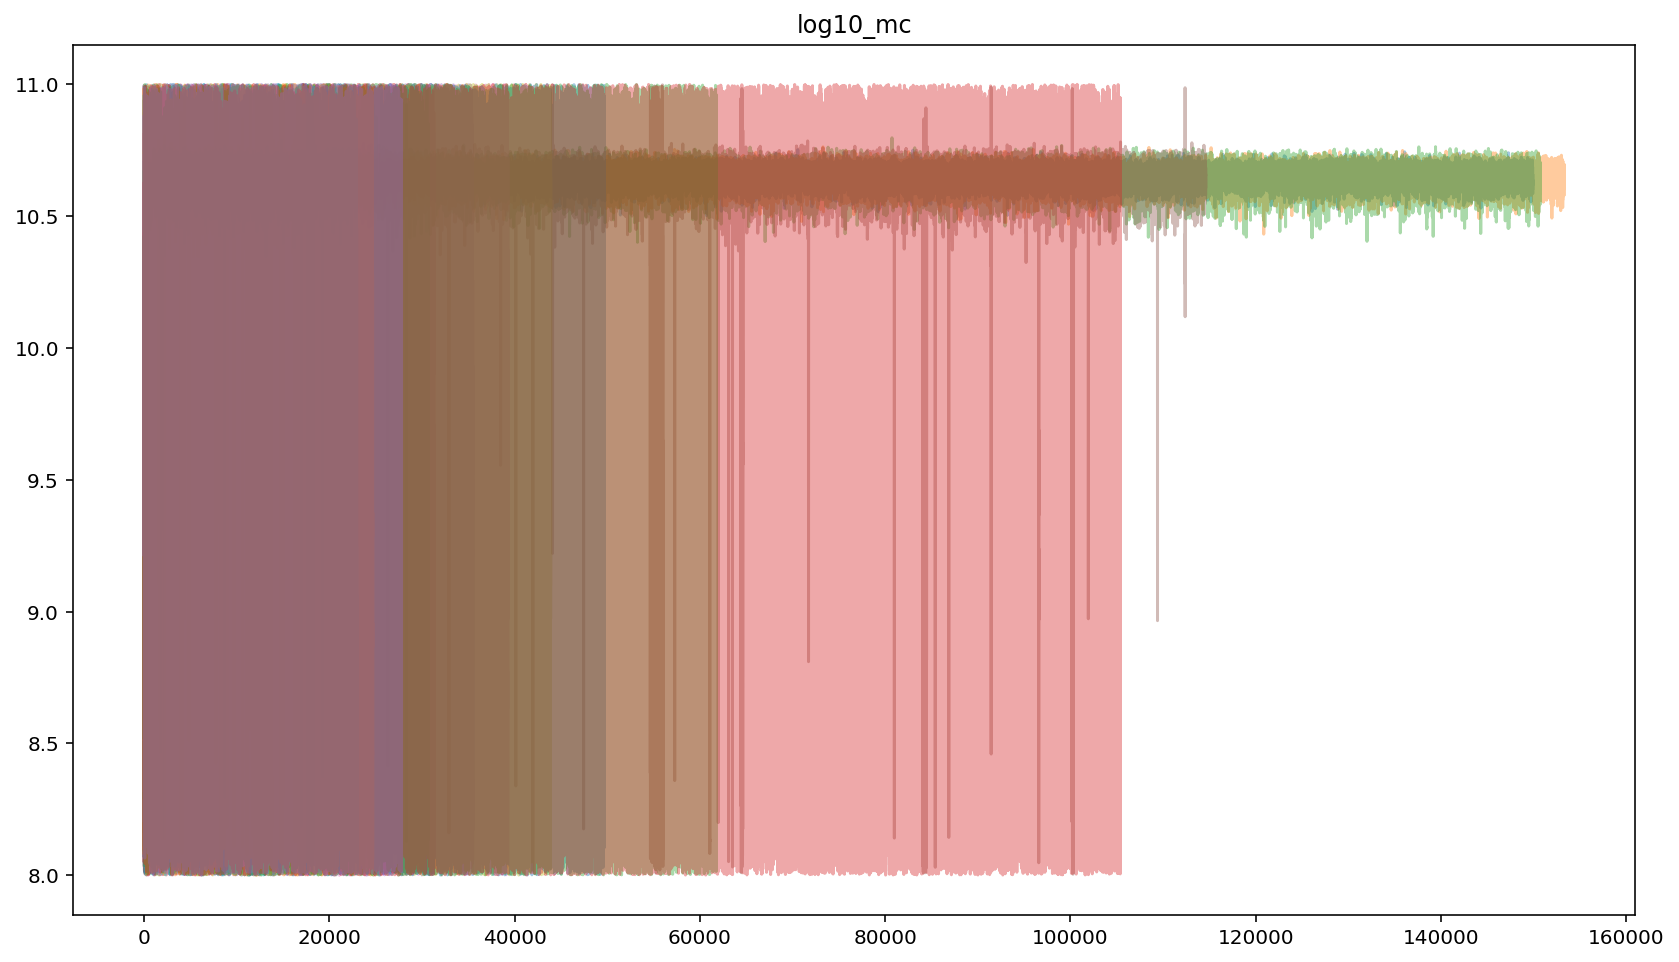

In [31]:
fig = plt.figure(figsize=(14,8))
for chain in all_chains:
    plt.plot(chain[:,12], alpha=0.4)
plt.title('log10_mc')
plt.savefig(datadir+'mc_traces.png')

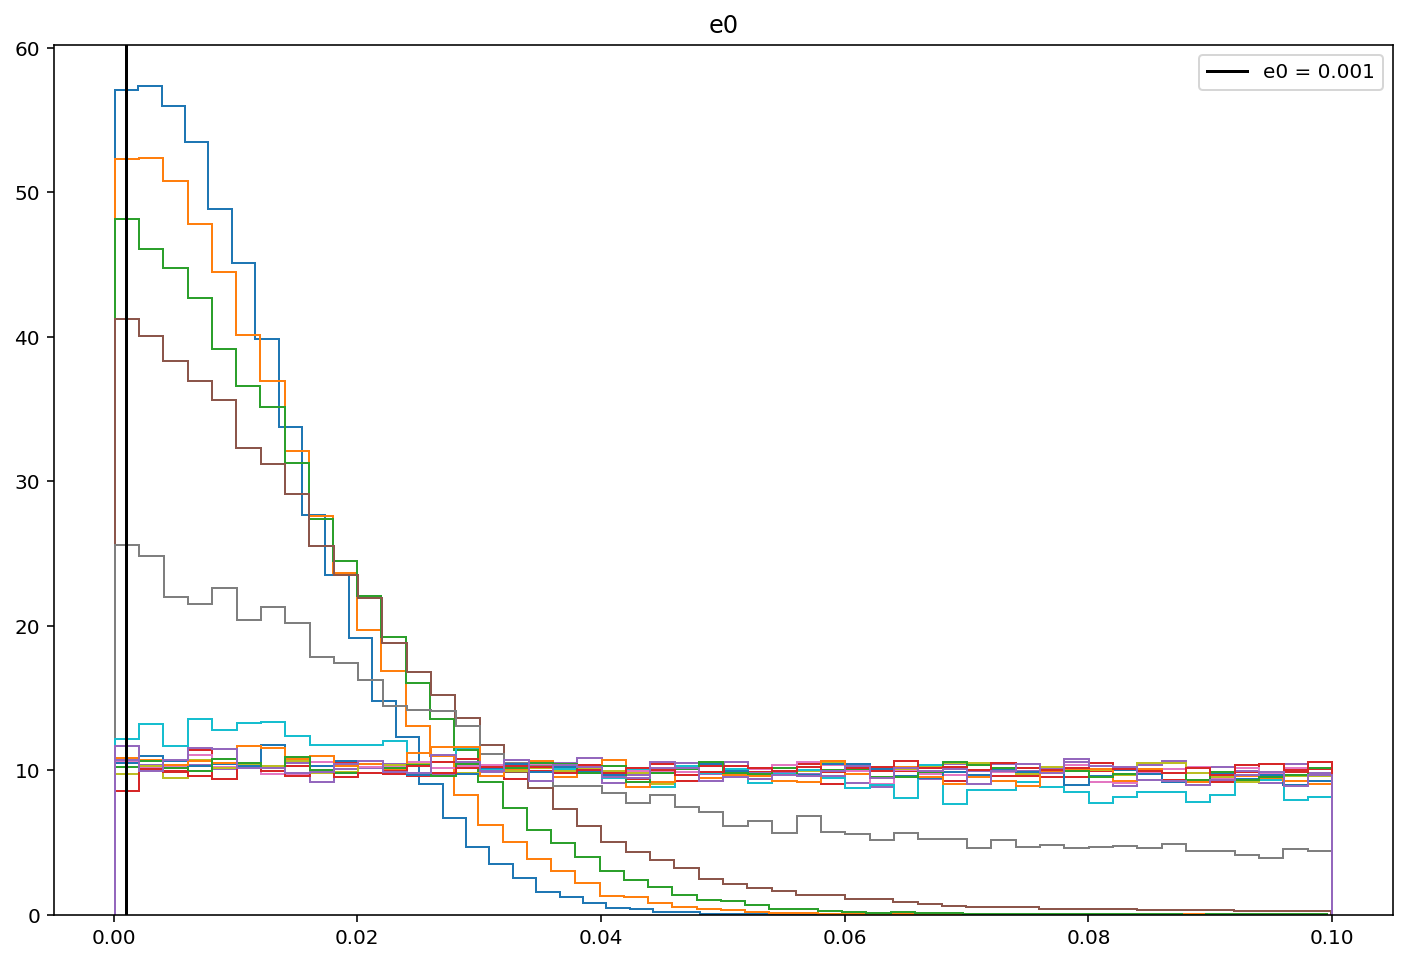

In [32]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
for chain in all_chains:
    ax.hist(chain[:,10], histtype='step', density=True, bins=50)
plt.axvline(x=0.001, color='black', label='e0 = 0.001')
plt.legend()
plt.title('e0')
plt.savefig(datadir+'e0_hist.png')

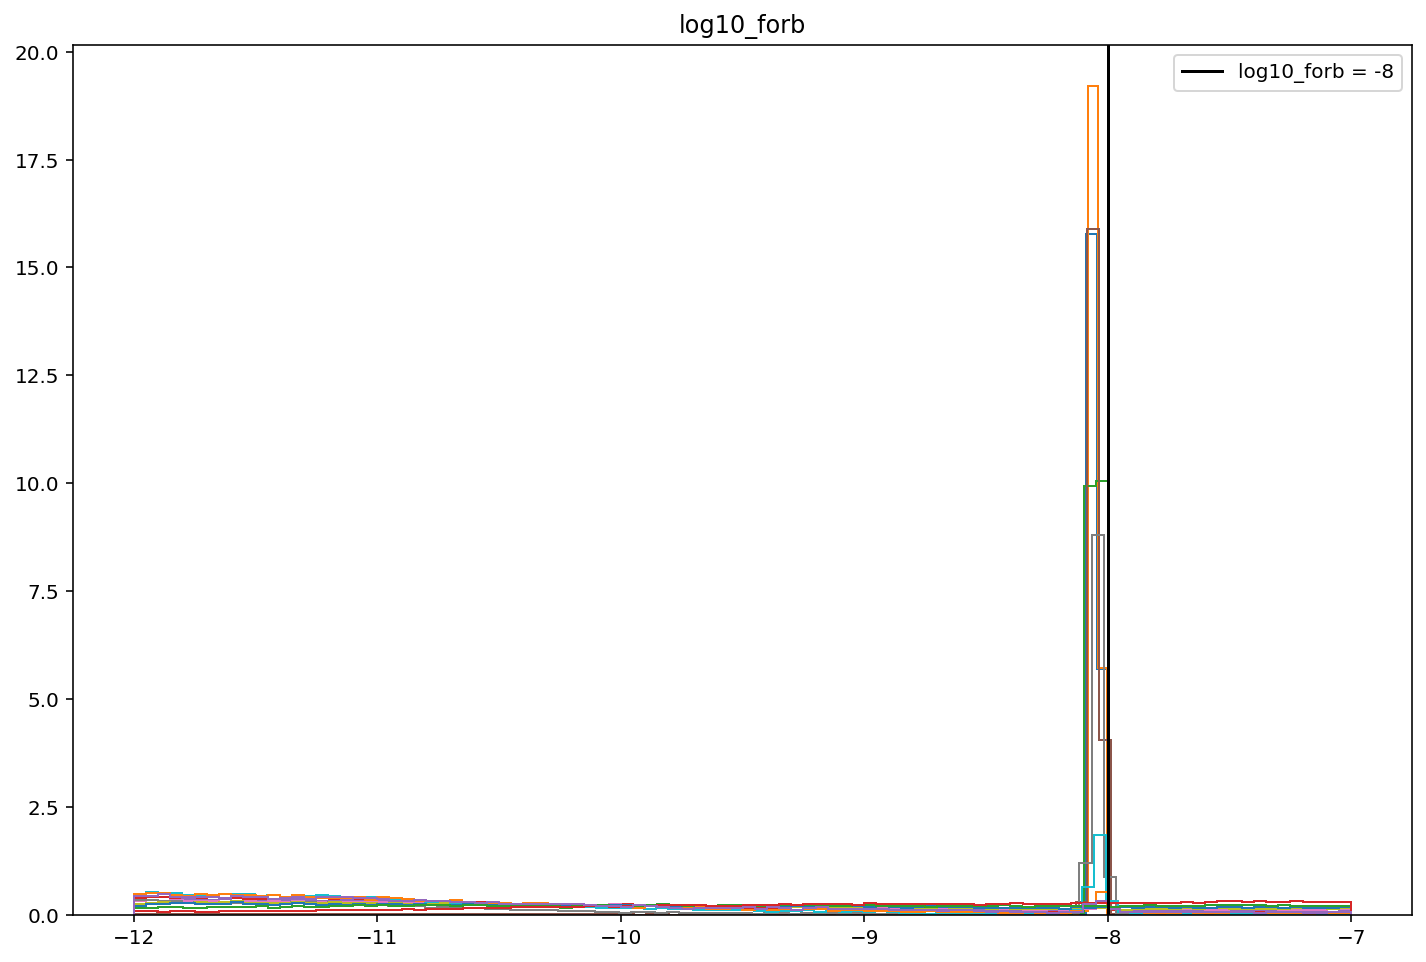

In [33]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
for chain in all_chains:
    ax.hist(chain[:,11], histtype='step', density=True, bins=100)
plt.axvline(x=-8.0, color='black', label='log10_forb = -8')
plt.legend()
#plt.xlim([-8.5,-7.8])
plt.title('log10_forb')
plt.savefig(datadir+'forb_hist.png')

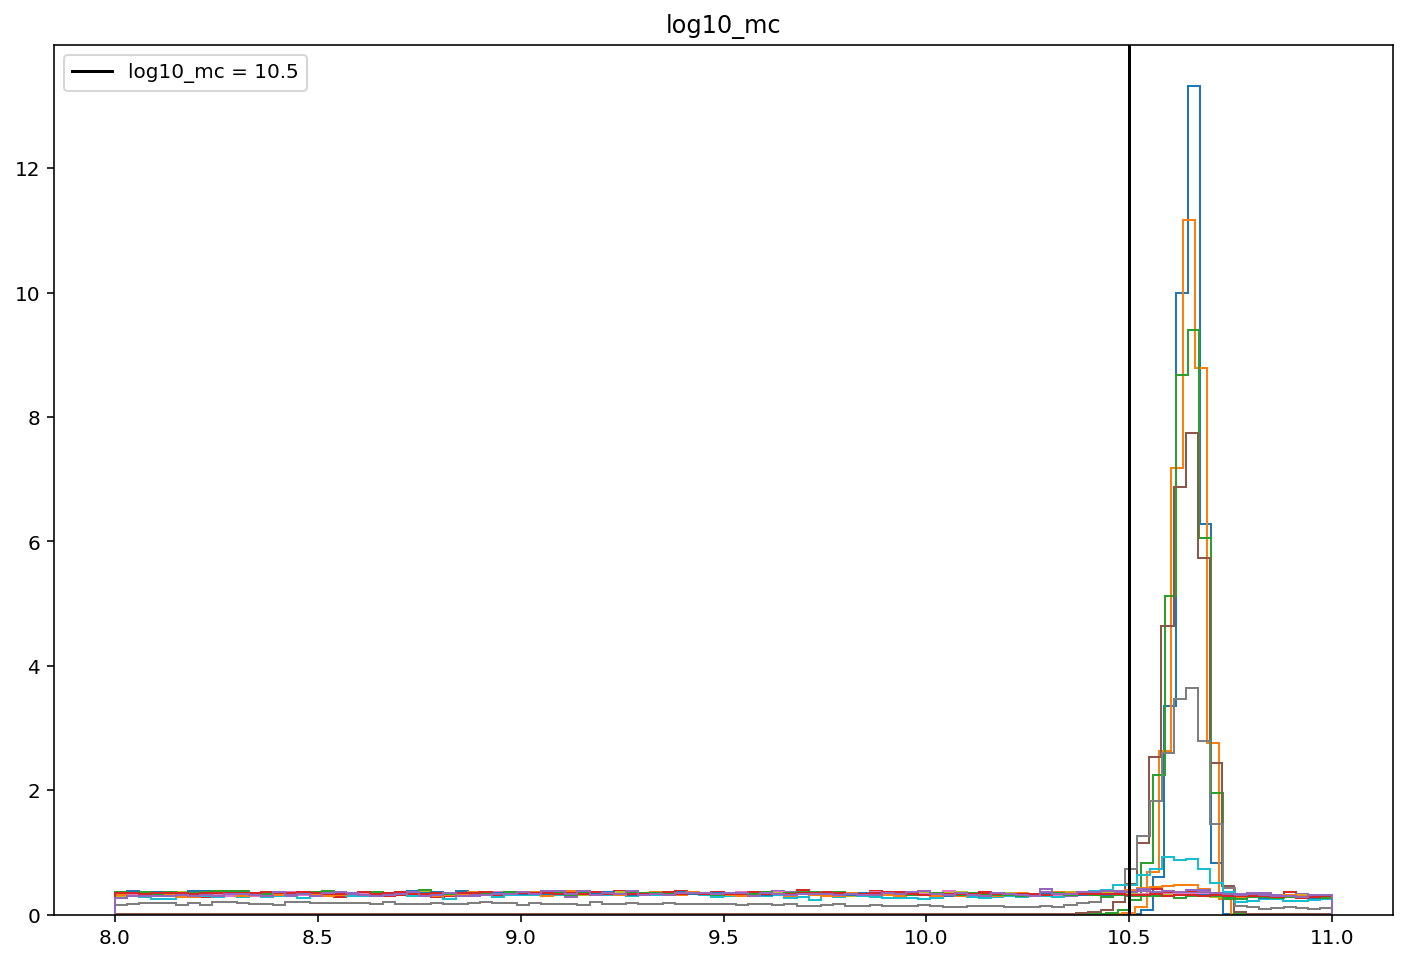

In [34]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
for chain in all_chains:
    ax.hist(chain[:,12], histtype='step', density=True, bins=100)
plt.axvline(x=10.5, color='black', label='log10_mc = 10.5')
plt.legend(loc=2)
plt.title('log10_mc')
plt.savefig(datadir+'mc_hist.png')

In [14]:
e0_temp_means = []
forb_temp_means = []
mc_temp_means = []

e0_temp_stds = []
forb_temp_stds = []
mc_temp_stds = []
for chain in all_chains:
    e0_temp_means.append(np.mean(chain[:,10]))
    forb_temp_means.append(np.mean(chain[:,11]))
    mc_temp_means.append(np.mean(chain[:,12]))
    
    e0_temp_stds.append(np.std(chain[:,10]))
    forb_temp_stds.append(np.std(chain[:,11]))
    mc_temp_stds.append(np.std(chain[:,12]))

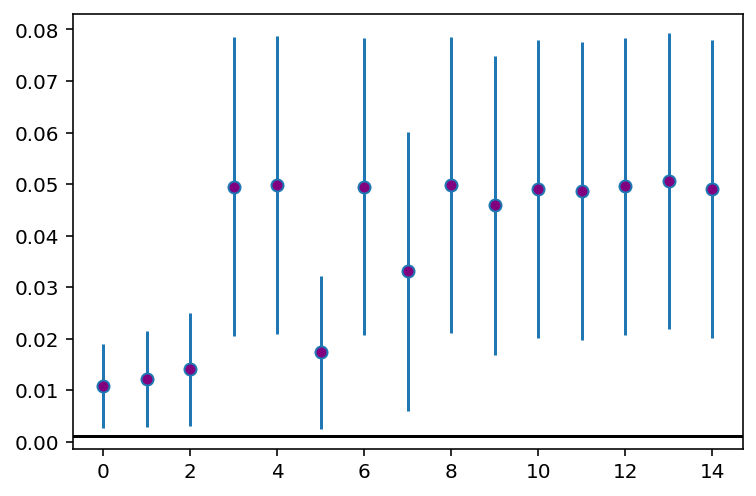

In [19]:
plt.errorbar(np.arange(len(e0_temp_means)), e0_temp_means, e0_temp_stds, fmt='o', mfc='purple')
plt.axhline(y=0.001, color='black')

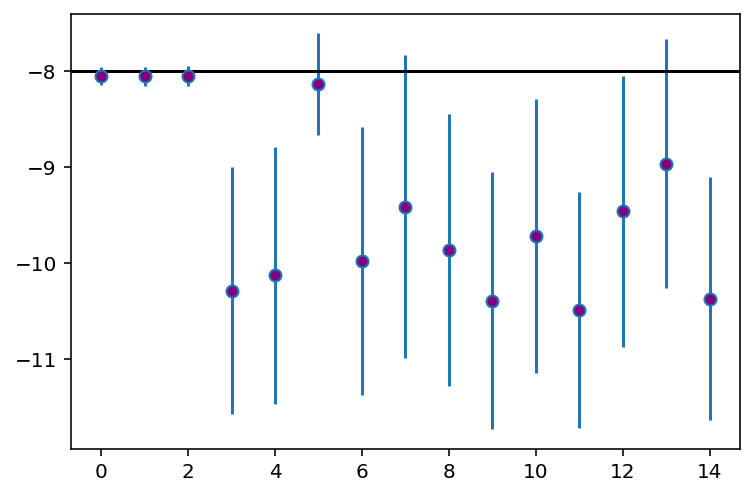

In [20]:
plt.errorbar(np.arange(len(forb_temp_means)), forb_temp_means, forb_temp_stds, fmt='o', mfc='purple')
plt.axhline(y=-8, color='black')

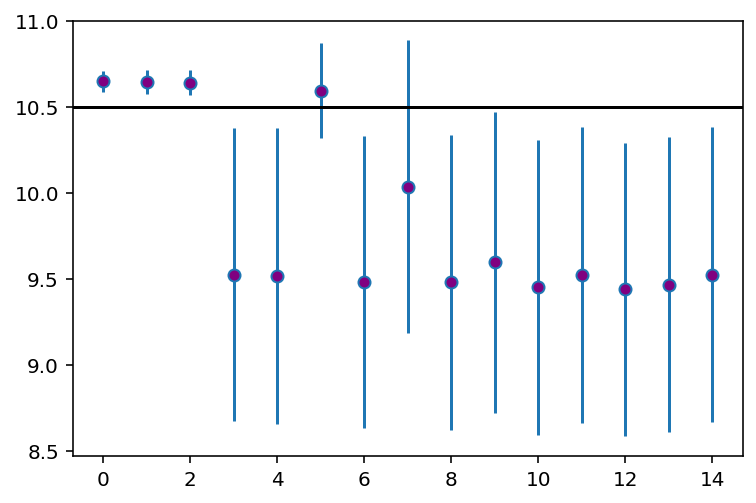

In [21]:
plt.errorbar(np.arange(len(mc_temp_means)), mc_temp_means, mc_temp_stds, fmt='o', mfc='purple')
plt.axhline(y=10.5, color='black')

In [7]:
e_samples = ecc_chain_run_1[:,10]
log10_mc_samples = ecc_chain_run_1[:,11]
mc_samples = 10**log10_mc_samples

In [18]:
e_samples[8]

0.2756097304643598

array([[<AxesSubplot:ylabel='log10_forb'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='log10_mc'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='e0', ylabel='q'>,
        <AxesSubplot:xlabel='log10_forb'>,
        <AxesSubplot:xlabel='log10_mc'>]], dtype=object)

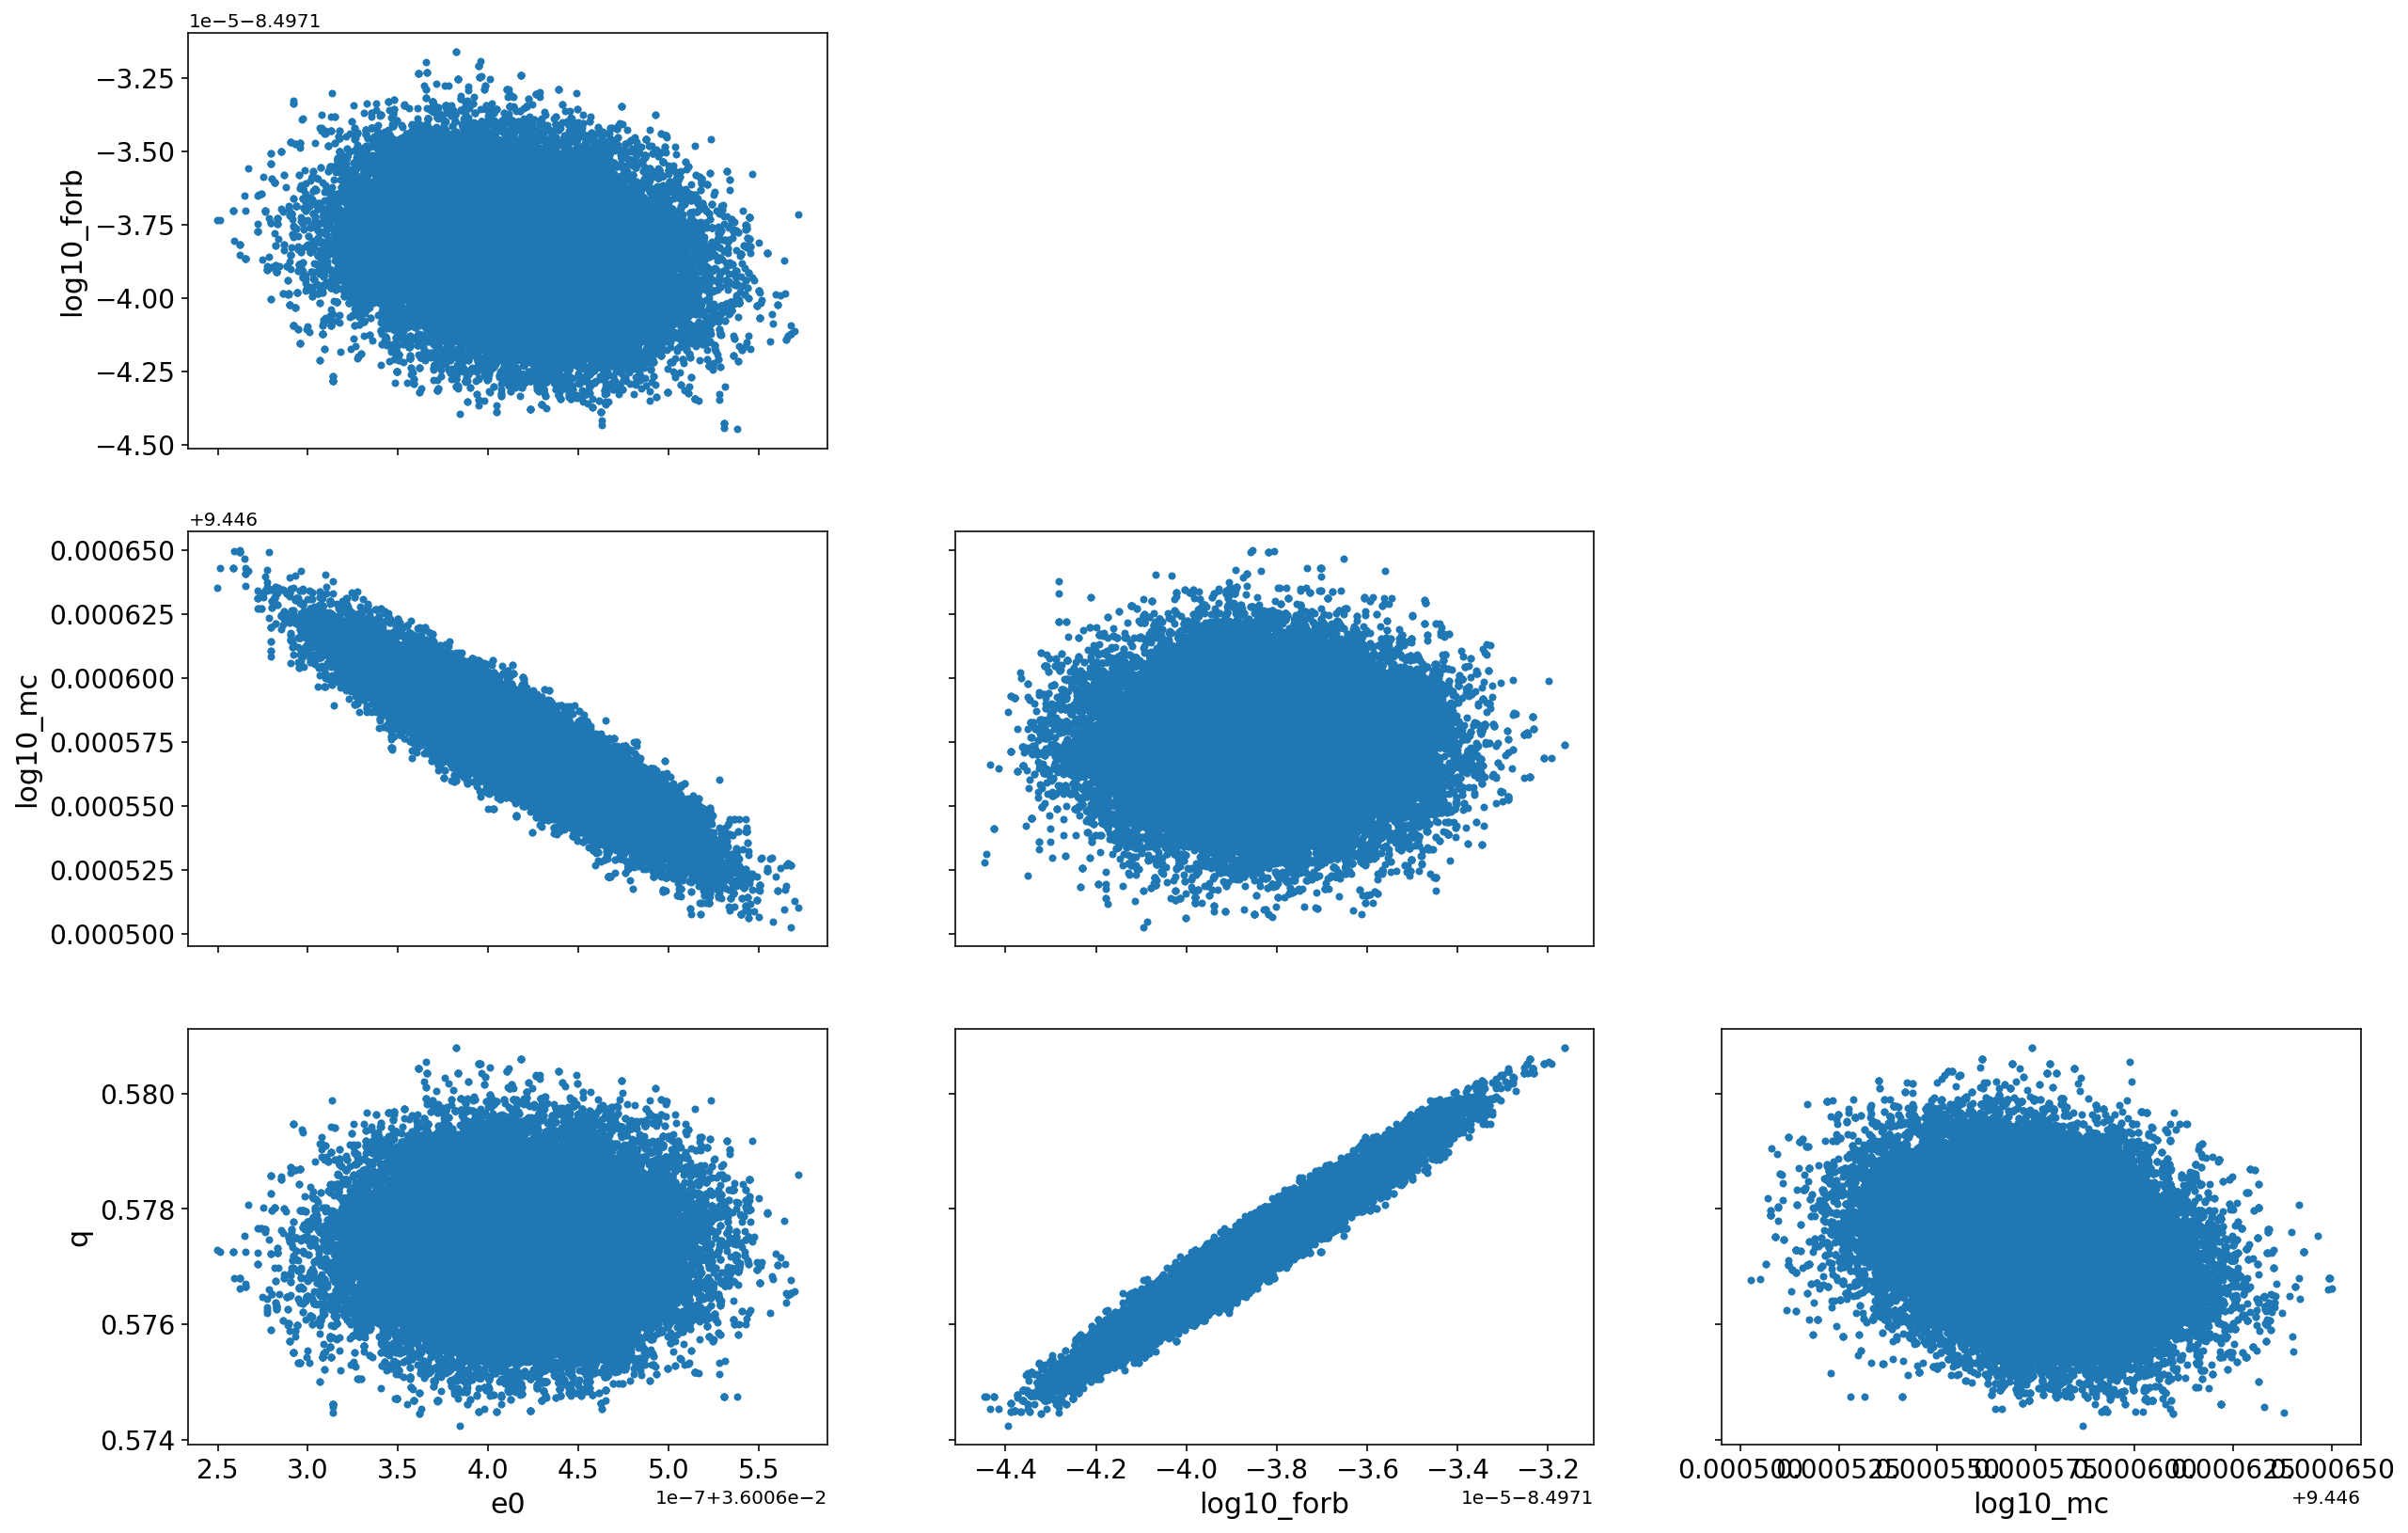

In [13]:
#e_mc_dict = {'e0':e_samples, 'mc':mc_samples}
#az_e_mc = az.convert_to_inference_data(e_mc_dict)

az.plot_pair(az_from_ecc_chains, var_names=ecc_param_list, kind='scatter')

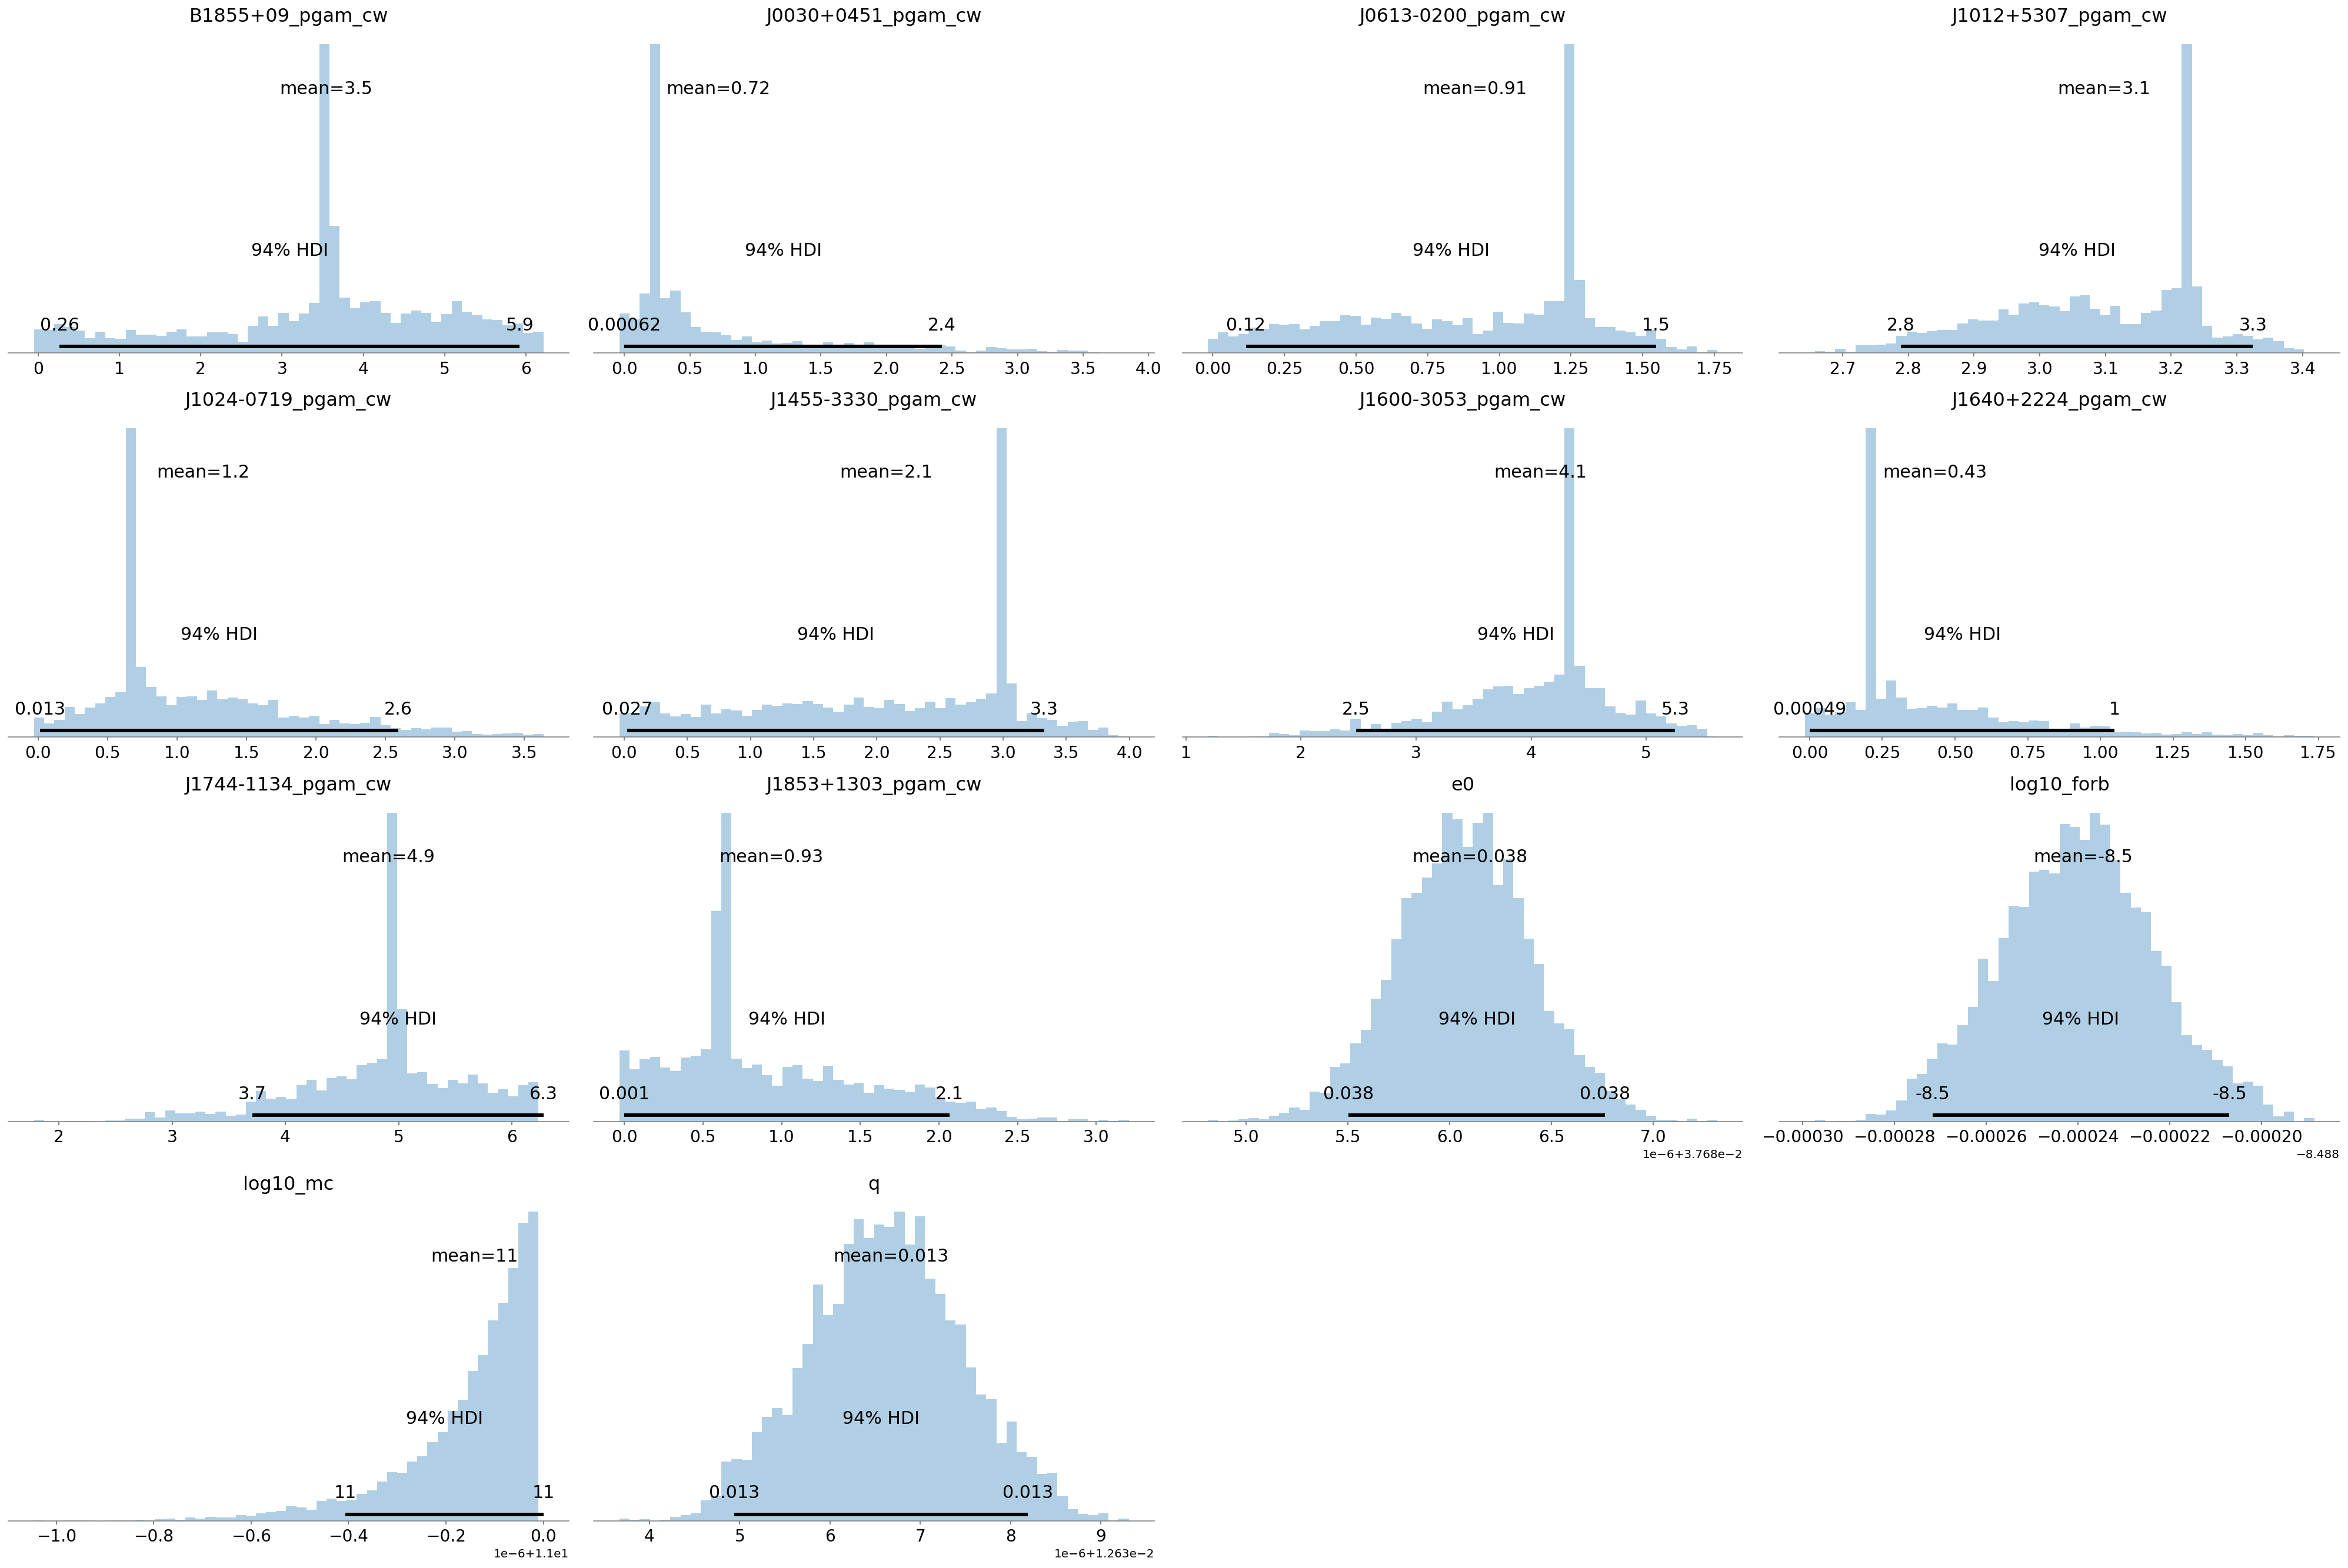

In [17]:
az.plot_posterior(az_from_ecc_chains, var_names=ecc_param_list, bins=50, kind='hist');

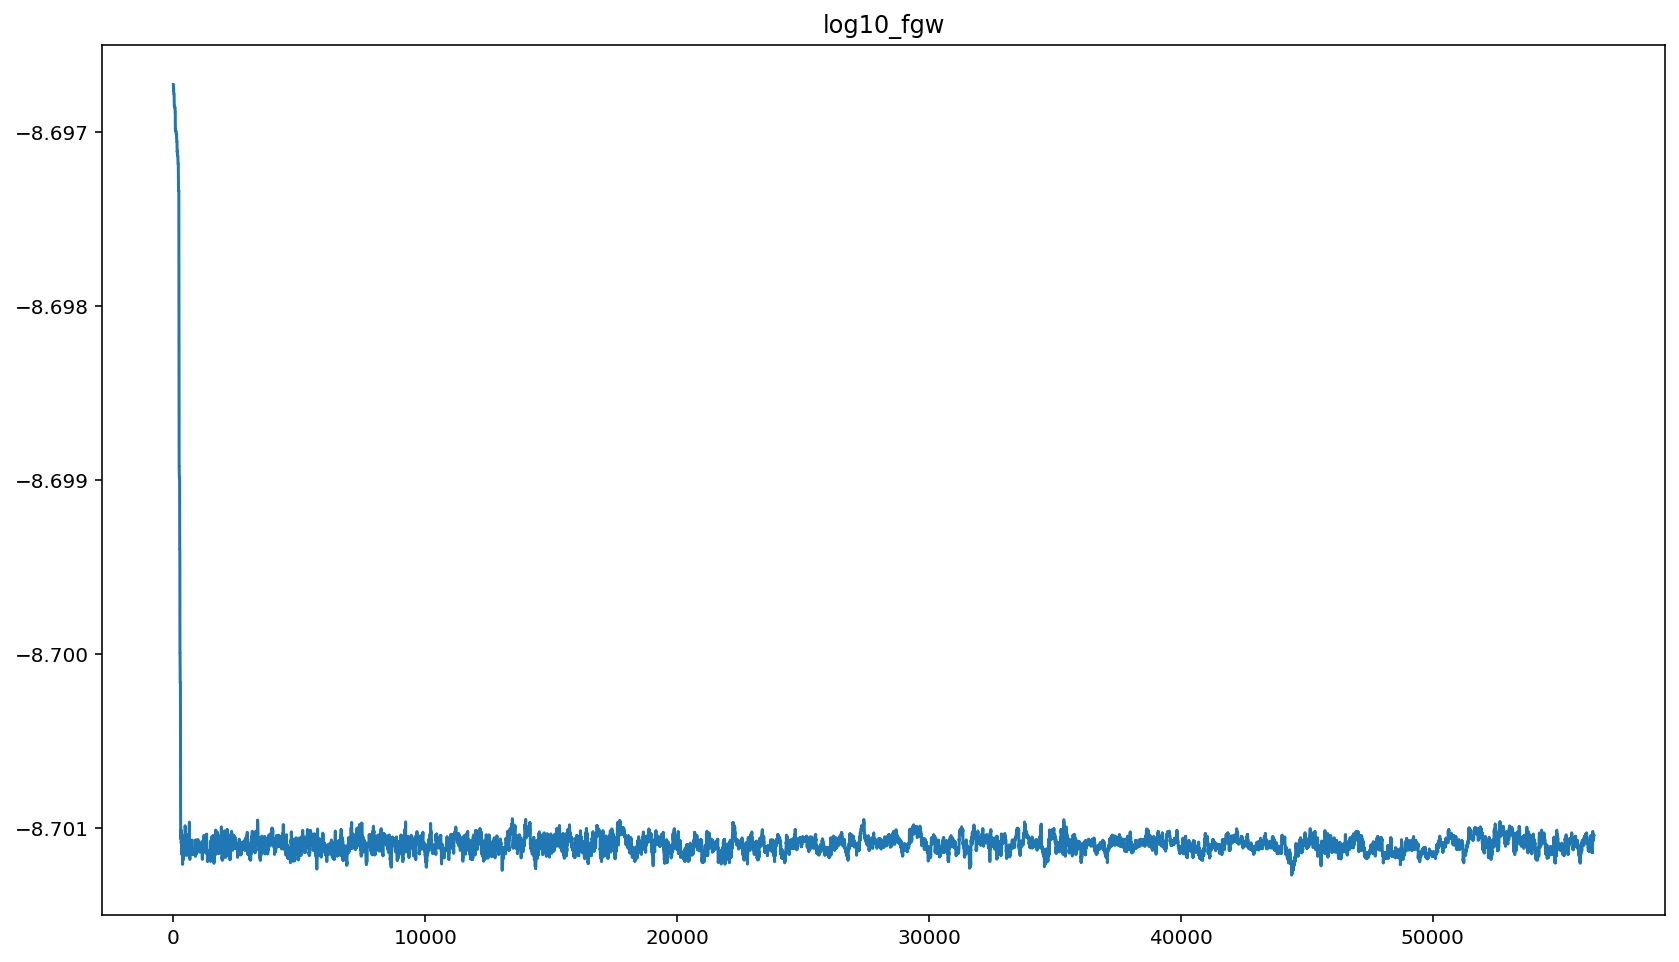

In [7]:
fig = plt.figure(figsize=(14,8))
ax = plt.gca()
ax.plot(ecc_chain_run_1[:,11])
#plt.xlim([0,500])
ax.set_title('log10_fgw')
plt.savefig(datadir+'log10_fgw_trace_plot.jpg')

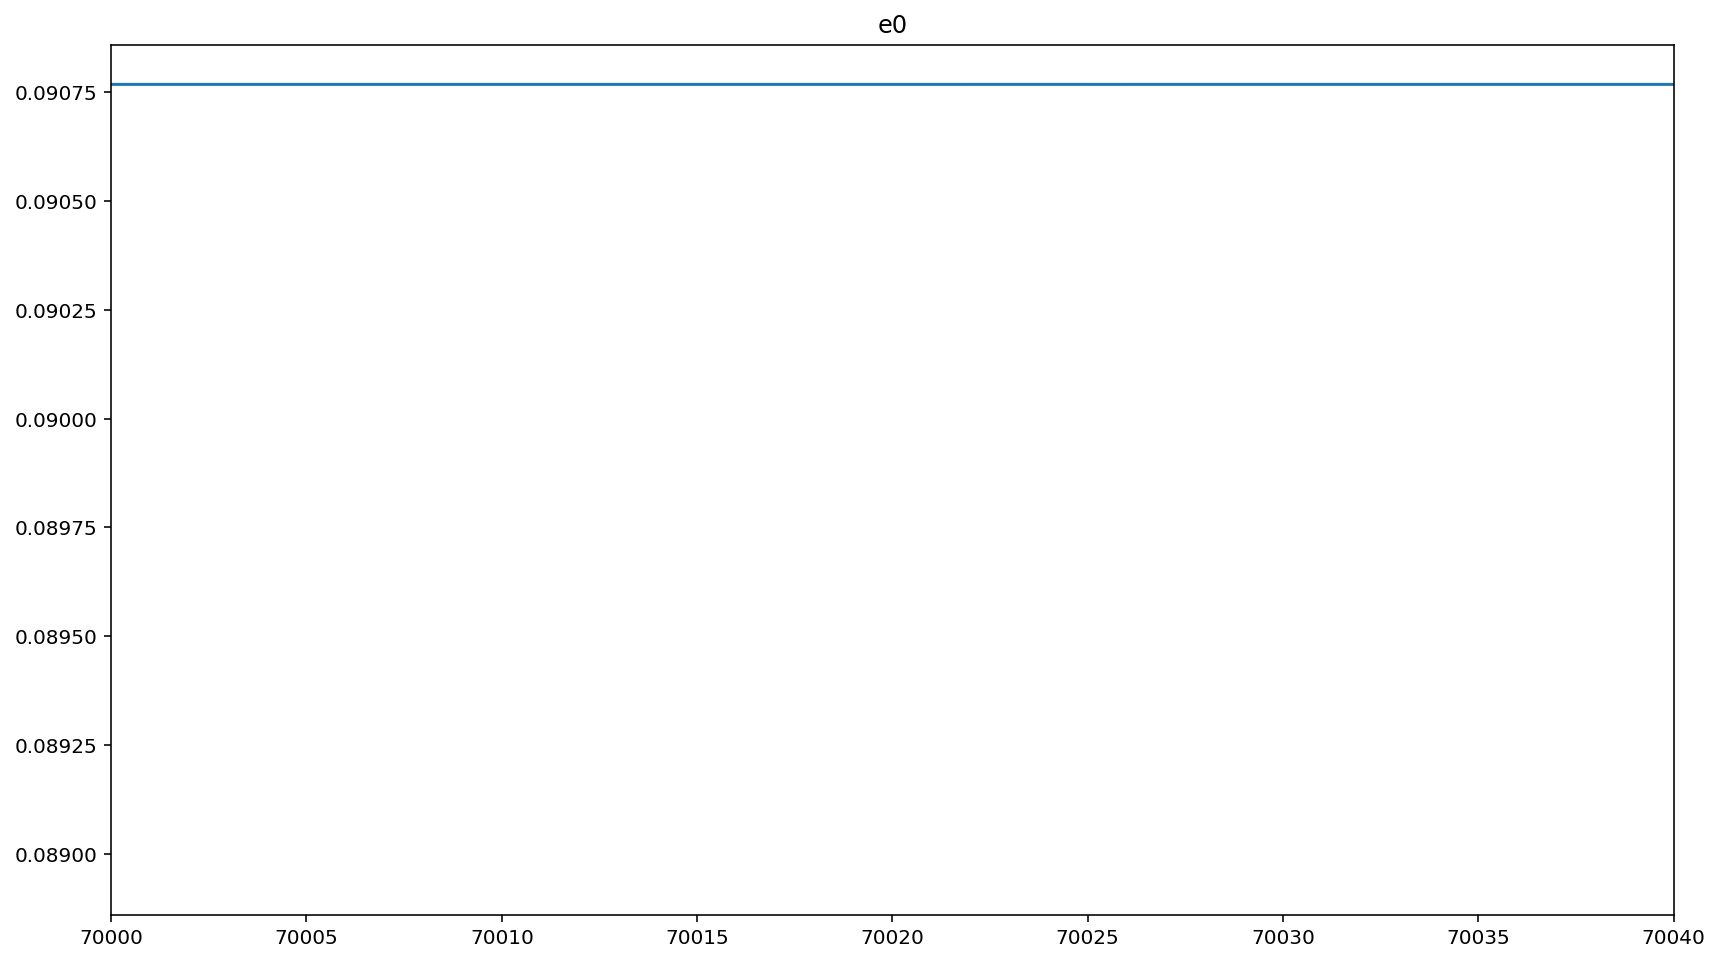

In [27]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.plot(ecc_chain_run_1[:,0])
plt.xlim([70000,70040])
ax.set_title('e0')
plt.savefig(datadir+'e0_trace_plot.jpg')

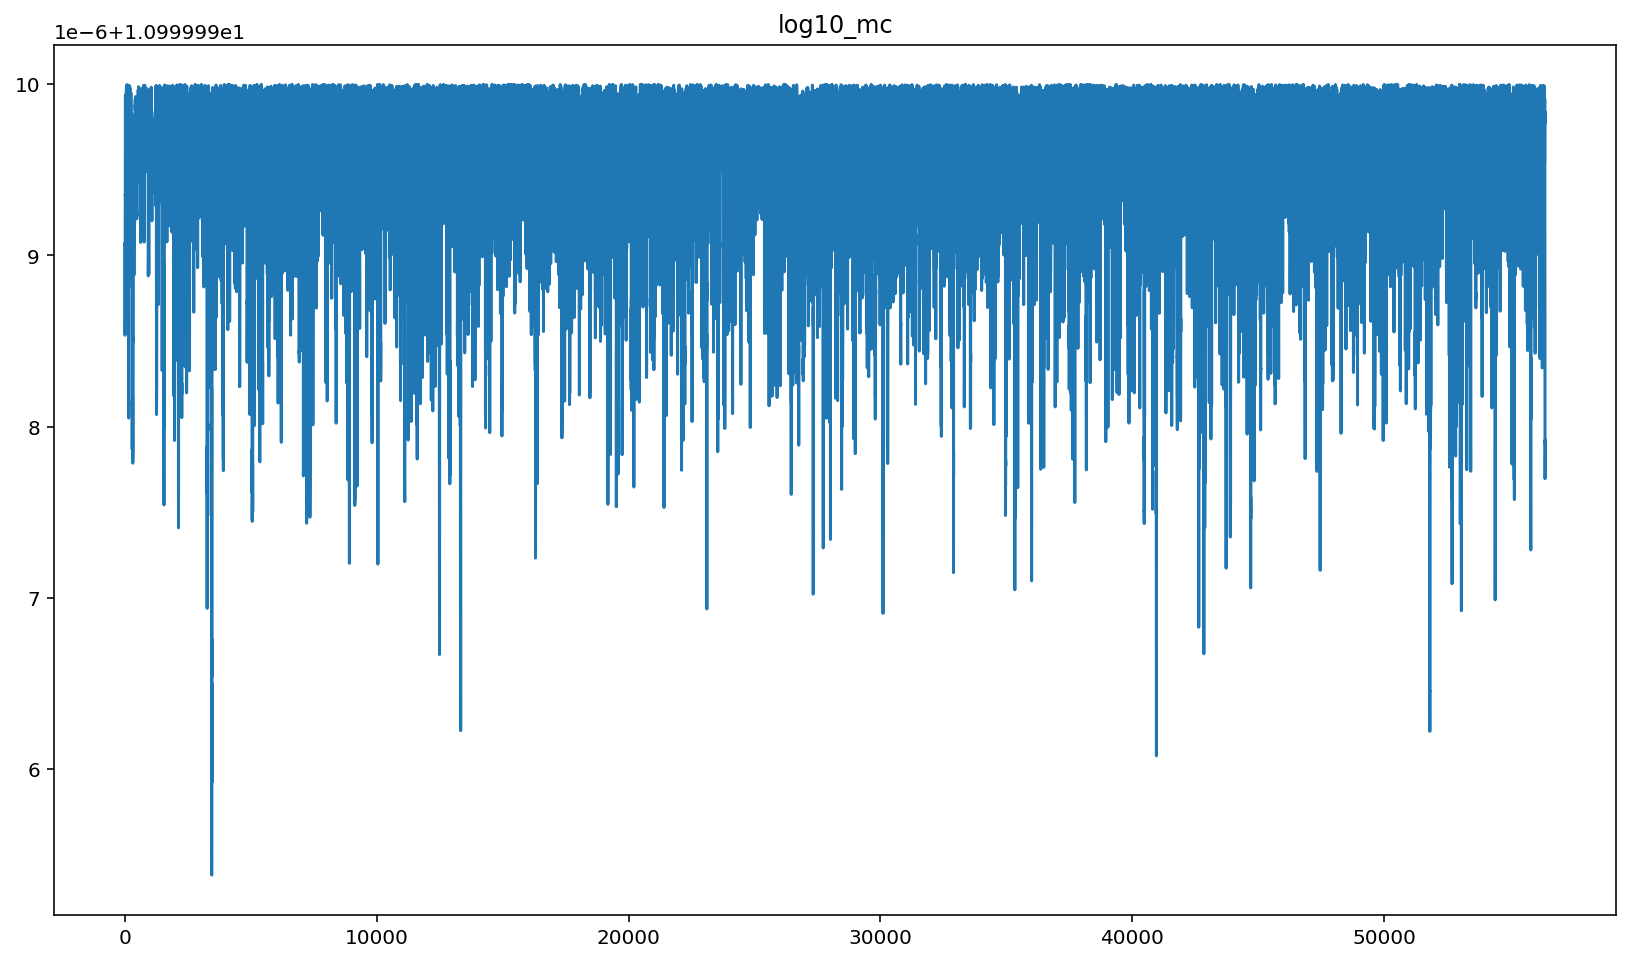

In [9]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.plot(ecc_chain_run_1[:,12])
#plt.xlim([0,500])
ax.set_title('log10_mc')
plt.savefig(datadir+'log10_mc_trace_plot.jpg')

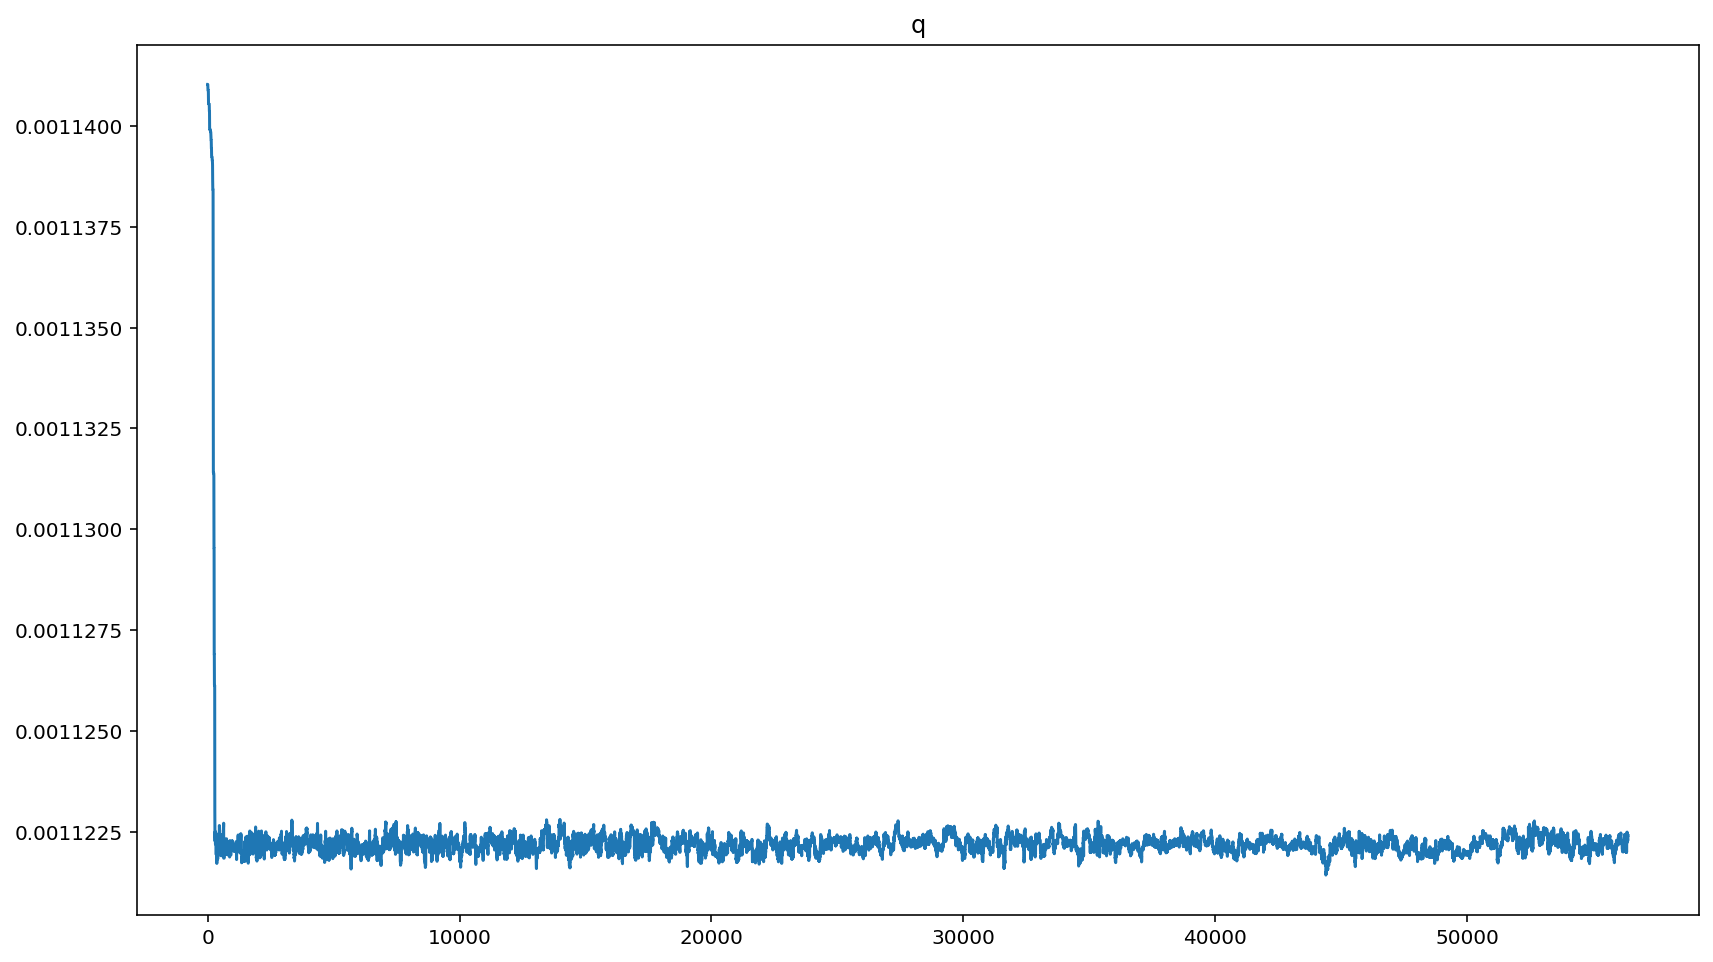

In [10]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.plot(ecc_chain_run_1[:,13])
#plt.xlim([0,500])
ax.set_title('q')
plt.savefig(datadir+'q_trace_plot.jpg')

In [37]:
mc_sigma = np.std(ecc_chain_run_1[:,12])

In [38]:
mc_mean = np.mean(ecc_chain_run_1[:,12])

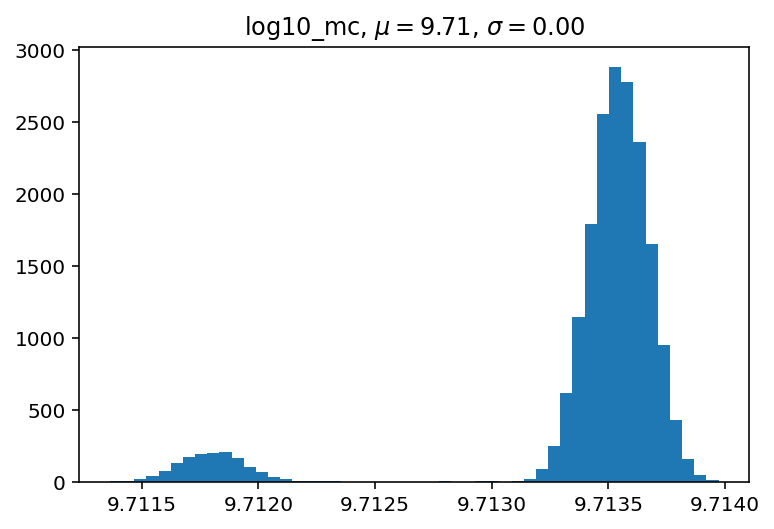

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(ecc_chain_run_1[:,12], bins=50, density=True);
#plt.axvline(x=10, color='black')
ax.set_title(r"log10_mc, $\mu = {:.2f}$, $\sigma = {:.2f}$".format(mc_mean, mc_sigma));
plt.savefig(datadir+'logmc_hist_plot.jpg')

In [21]:
e_sigma = np.std(ecc_chain_run_1[:,10])
e_mean = np.mean(ecc_chain_run_1[:,10])

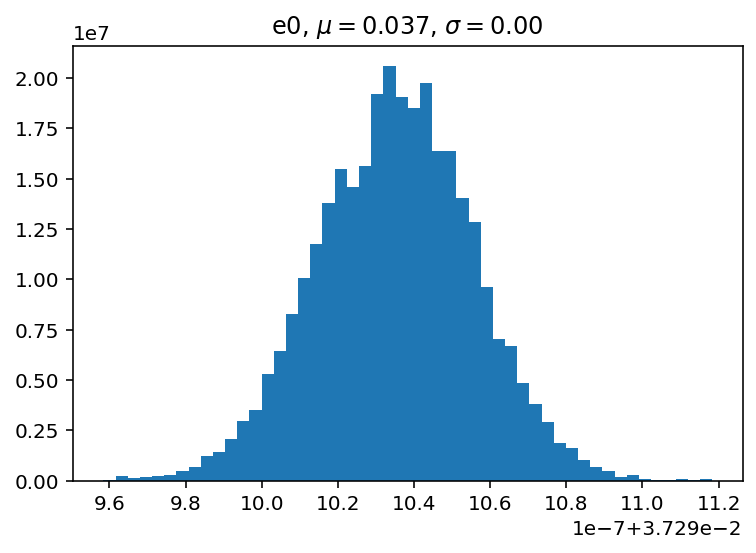

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(ecc_chain_run_1[:,10], bins=50, density=True);
#plt.axvline(x=0.01, color='black')
ax.set_title(r"e0, $\mu = {:.3f}$, $\sigma = {:.2f}$".format(e_mean, e_sigma));
plt.savefig(datadir+'e0_hist_plot.jpg')

In [23]:
q_sigma = np.std(ecc_chain_run_1[:,13])
q_mean = np.mean(ecc_chain_run_1[:,13])

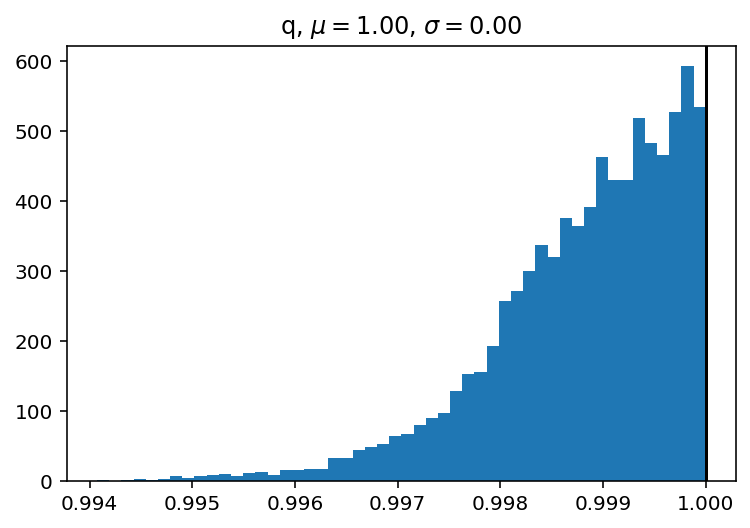

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(ecc_chain_run_1[:,13], bins=50, density=True);
plt.axvline(x=1, color='black')
ax.set_title(r"q, $\mu = {:.2f}$, $\sigma = {:.2f}$".format(q_mean, q_sigma));
plt.savefig(datadir+'q_hist_plot.jpg')

In [25]:
f_sigma = np.std(ecc_chain_run_1[:,11])
f_mean = np.mean(ecc_chain_run_1[:,11])

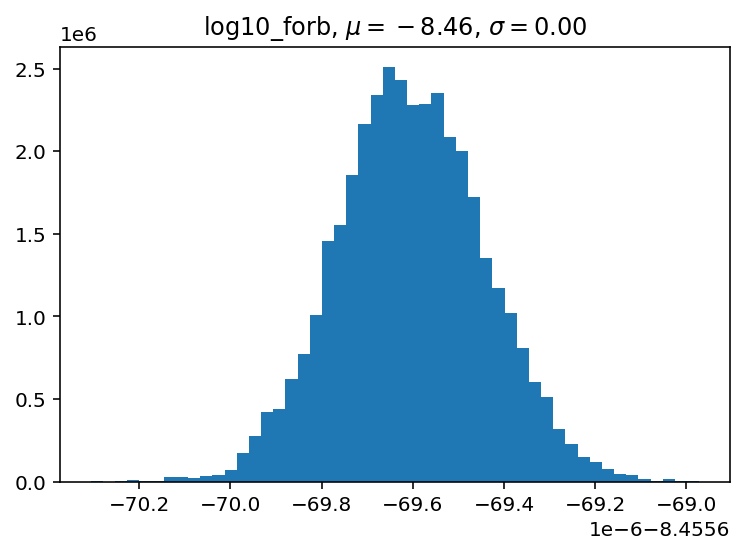

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(ecc_chain_run_1[:,11], bins=50, density=True);
#plt.axvline(x=-8.5, color='black')
ax.set_title(r"log10_forb, $\mu = {:.2f}$, $\sigma = {:.2f}$".format(f_mean, f_sigma));
plt.savefig(datadir+'log10_forb_hist_plot.jpg')